In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

C:\Users\PEIM001\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


## Filter with a threshold on class scores

In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, -1)
    box_class_scores = K.max(box_scores, -1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores > threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [3]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


## Non-max suppression

In [4]:
def iou(box1, box2):

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

In [5]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [7]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [8]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [9]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


## Test YOLO pretrained model

In [10]:
sess = K.get_session()

In [11]:
class_names = read_classes("model_data/coco_classes.txt")

anchors = read_anchors("model_data/yolo_anchors.txt")

image_shape = (720., 1280.)    

In [12]:
yolo_model = load_model("model_data/yolo.h5")

C:\Users\PEIM001\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [14]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [15]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [16]:
def predict(sess, image_file):

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # Use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


C:\Users\PEIM001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


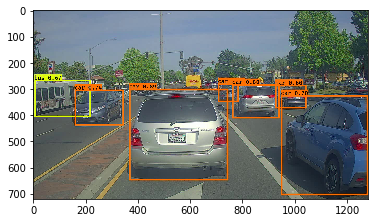

In [20]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 2 boxes for 0007.jpg
car 0.67 (1086, 243) (1225, 312)
car 0.78 (468, 292) (685, 353)


C:\Users\PEIM001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


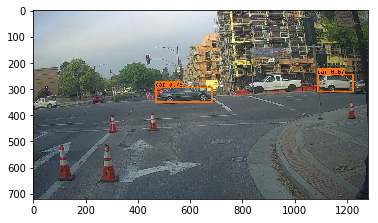

In [21]:
out_scores, out_boxes, out_classes = predict(sess, "0007.jpg")